# Analysis of Divvy Usage and Chicago Weather

Joint analysis of Divvy bikesharing data and Chicago weather from April 2020 to May 2023. [View this notebook on NBViewer](https://nbviewer.org/github/pollyren/divvy/blob/main/analysis/weather_analysis.ipynb) to see the proper map renderings.

### Preliminaries

In [1]:
import pandas as pd
import os
from datetime import datetime
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import folium

In [2]:
dtypes = {
    'temp': float,
    'feelslike': float,
    'dew': float,
    'humidity': float,
    'precip': float,
    'snowdepth': float,
    'windspeed': float,
    'winddir': float,
    'sealevelpressure': float,
    'cloudcover': float,
    'visibility': float,
    'uvindex': float,
    'severerisk': str,
    'conditions': str,
    'icon': str,
    'year': int,
    'month': int,
    'day': int,
    'hour': int,
    'member_classic_counts': float,
    'member_electric_counts': float,
    'casual_classic_counts': float,
    'casual_electric_counts': float,
    'member_classic_avg_time': float,
    'member_electric_avg_time': float,
    'casual_classic_avg_time': float,
    'casual_electric_avg_time': float,
    'member_classic_avg_dist': float,
    'member_electric_avg_dist': float,
    'casual_classic_avg_dist': float,
    'casual_electric_avg_dist': float,
    'total_avg_time': float,
    'total_avg_dist': float,
    'total_classic_counts': float,
    'total_electric_counts': float,
    'total_member_counts': float,
    'total_casual_counts': float,
    'pop_station': str
}

In [3]:
data_path = os.getcwd() + '/../data/'
data = pd.read_csv(data_path+'bike_weather_merged.csv', dtype=dtypes, index_col=0)

In [4]:
data['total_counts'] = data['total_member_counts'].fillna(0) + data['total_casual_counts'].fillna(0)

In [5]:
data.columns

Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'snowdepth',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'uvindex', 'conditions', 'icon', 'year', 'month', 'day', 'hour',
       'member_classic_counts', 'member_electric_counts',
       'casual_classic_counts', 'casual_electric_counts',
       'member_classic_avg_time', 'member_electric_avg_time',
       'casual_classic_avg_time', 'casual_electric_avg_time',
       'member_classic_avg_dist', 'member_electric_avg_dist',
       'casual_classic_avg_dist', 'casual_electric_avg_dist', 'total_avg_time',
       'total_avg_dist', 'total_classic_counts', 'total_electric_counts',
       'total_member_counts', 'total_casual_counts', 'pop_station',
       'total_counts'],
      dtype='object')

In [6]:
totals = [metric for metric in data.columns if 'total' in metric]
numeric_data = data.select_dtypes(include='number').drop(['year','month','day','hour']+totals, axis=1)

In [7]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27744 entries, 0 to 27743
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   temp                      27744 non-null  float64
 1   feelslike                 27744 non-null  float64
 2   dew                       27744 non-null  float64
 3   humidity                  27744 non-null  float64
 4   precip                    27744 non-null  float64
 5   snowdepth                 27744 non-null  float64
 6   windspeed                 27744 non-null  float64
 7   winddir                   27744 non-null  float64
 8   sealevelpressure          27744 non-null  float64
 9   cloudcover                27744 non-null  float64
 10  visibility                27744 non-null  float64
 11  uvindex                   27744 non-null  float64
 12  member_classic_counts     27447 non-null  float64
 13  member_electric_counts    24520 non-null  float64
 14  casual_clas

In [8]:
data.head()

,temp,feelslike,dew,humidity,precip,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,...,casual_classic_avg_dist,casual_electric_avg_dist,total_avg_time,total_avg_dist,total_classic_counts,total_electric_counts,total_member_counts,total_casual_counts,pop_station,total_counts
0,38.6,32.9,34.4,84.67,0.0,0.0,8.0,357.0,1018.1,95.5,...,1.992716,NaN,9.327273,1.014547,11.0,NaN,9.0,2.0,Kingsbury St & Erie St,11.0
1,38.6,32.2,34.4,84.67,0.0,0.0,9.5,360.0,1017.9,99.3,...,NaN,NaN,7.141667,0.885256,2.0,NaN,2.0,NaN,May St & Taylor St,2.0
2,38.6,32.7,34.4,84.67,0.0,0.0,8.4,358.0,1017.6,89.4,...,2.370126,NaN,22.291667,1.185063,2.0,NaN,1.0,1.0,Michigan Ave & Madison St,2.0
3,38.6,33.0,34.1,83.77,0.0,0.0,7.8,327.0,1017.6,75.0,...,0.620873,NaN,17.425000,0.974012,4.0,NaN,2.0,2.0,Emerald Ave & 28th St,4.0
4,38.6,33.2,34.1,83.77,0.0,0.0,7.4,358.0,1017.6,70.7,...,NaN,NaN,8.016667,1.014499,4.0,NaN,4.0,NaN,Rush St & Cedar St,4.0


### Correlation Analysis

Here, I will perform correlation analysis between the datapoints in the bike dataset and the weather dataset. The goal is to identify which weather elements have the greatest bearing on users' choice to ride, ride duration, and ride distance. Ultimately this information will also enable us to better predict when bikes will be used and perhaps even where optimal locations for bike docks would be.

In [78]:
member_casual = ['member','casual']
classic_electric = ['classic','electric']
colours = ['#D5573B','#074F57','#449DD1','#0E0E52']

<Axes: >

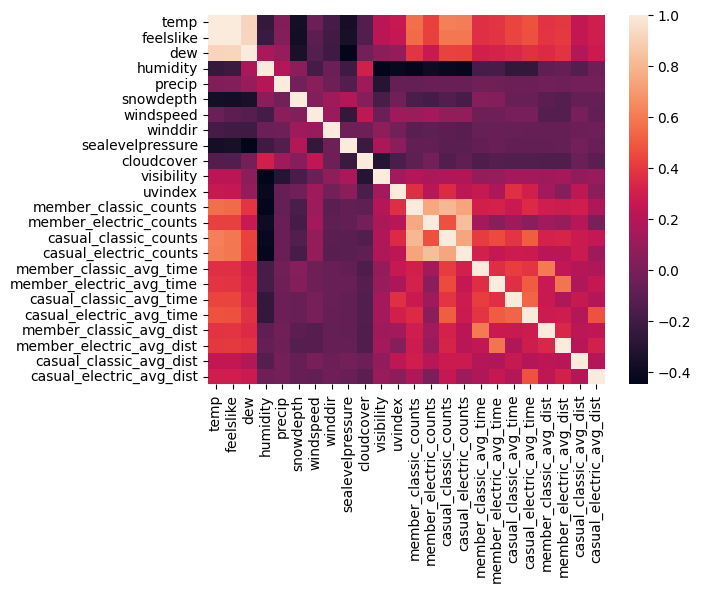

In [10]:
sns.heatmap(numeric_data.corr())

#### Temperature

Text(0.5, 1.0, 'hourly rides in varying temperatures (cumulative)')

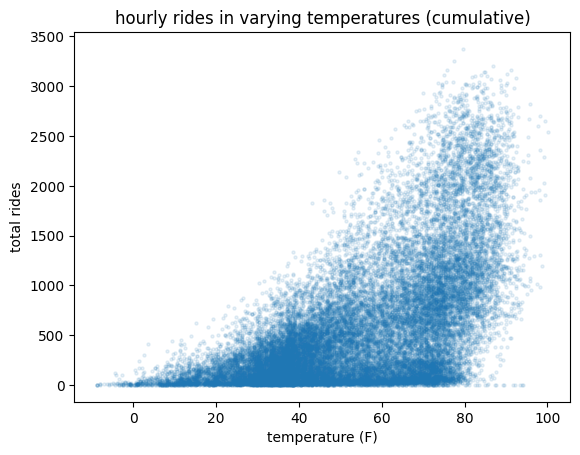

In [45]:
plt.scatter(data['temp'], data['total_counts'], s=5, alpha=0.1)
plt.xlabel('temperature (F)')
plt.ylabel('total rides')
plt.title('hourly rides in varying temperatures (cumulative)')

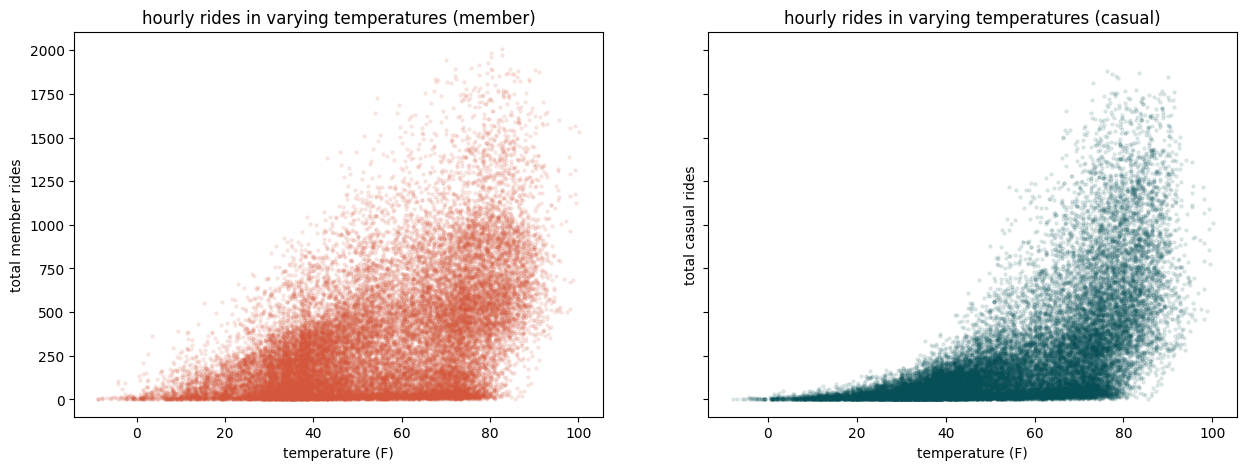

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
for i in range(2):
    axes[i].scatter(data['temp'], data['total_{}_counts'.format(member_casual[i])], s=5, c=colours[i], alpha=0.1)
    axes[i].set_xlabel('temperature (F)')
    axes[i].set_ylabel('total {} rides'.format(member_casual[i]))
    axes[i].set_title('hourly rides in varying temperatures ({})'.format(member_casual[i]))

In [72]:
for i in range(2):
    tmp = member_casual[i]
    print(
        f'Average temperature for {tmp} riders:', 
        (data['temp']*data[f'total_{tmp}_counts']).sum() / data[f'total_{tmp}_counts'].sum()
    )

Average temperature for member riders: 63.99863072589778
Average temperature for casual riders: 70.37081153824859


The casual rider... !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

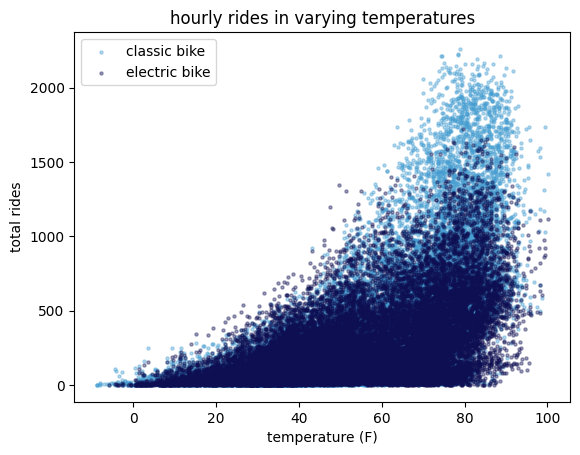

In [98]:
fig, ax = plt.subplots()

for i, ride_type in enumerate(classic_electric):
    ax.scatter(
        data['temp'], 
        data[f'total_{ride_type}_counts'], 
        s=5, 
        c=colours[i+2], 
        alpha=0.38, 
        label=f'{ride_type} bike'
    )

ax.set_xlabel('temperature (F)')
ax.set_ylabel('total rides')
ax.set_title('hourly rides in varying temperatures')
ax.legend()

In [82]:
for i in range(2):
    tmp = classic_electric[i]
    print(
        f'Average temperature during {tmp} bike rides:', 
        (data['temp']*data[f'total_{tmp}_counts']).sum() / data[f'total_{tmp}_counts'].sum()
    )

Average temperature during classic bike rides: 68.42611714079119
Average temperature during electric bike rides: 63.89244050692277


The distribution of hourly ...